<a href="https://colab.research.google.com/github/Bahrombekk/pytorch/blob/main/Data_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn.functional as F
import glob

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# from torchinfo import summary
from torchsummary import summary
import pathlib
from PIL import Image
from torchvision.transforms import transforms
from torch.optim import Adam

import torchvision.transforms as T

In [2]:
!pip install torchinfo

In [3]:
! wget -O dataset.zip https://www.dropbox.com/s/e5f4epncmydijrw/Komp_in_tel.zip?dl=0

--2023-07-09 16:38:38--  https://www.dropbox.com/s/e5f4epncmydijrw/Komp_in_tel.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/e5f4epncmydijrw/Komp_in_tel.zip [following]
--2023-07-09 16:38:38--  https://www.dropbox.com/s/raw/e5f4epncmydijrw/Komp_in_tel.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc24a0f1a2652a6206f02413f273.dl.dropboxusercontent.com/cd/0/inline/B_j4B7cZA4JpwvNP_dEz1SInk6zyJ_FRCj5Q864Qdcgx_MgNOm-0TyS-n3i-_g5UJpQJCKMEOAicWQGTDRF2fkuvbXXWUOE_Qz-mJEMkVXeWt87Iy61JGcRnbYNWoOCUobZqvXYV-3-k9pnMHLQQIjehhFHAh7TLG3dnwN0-2K4tmw/file# [following]
--2023-07-09 16:38:39--  https://uc24a0f1a2652a6206f02413f273.dl.dropboxusercontent.com/cd/0/inline/B_j4B7cZA4JpwvNP_dEz1SInk6zyJ_FRCj5Q864Qdcgx_MgNOm-0TyS-n3i-_g5

In [ ]:
!unzip dataset.zip

In [55]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [56]:
transform = T.Compose([
    T.Resize(size=(150,150)),
    T.ToTensor()
])

In [71]:
class KOMP_in_tel_Dataset(Dataset):

    def __init__(self, path, transform = None):
        # int for cross entryp loss
        self.path_list = list(path.glob('*/*.jpg'))
        self.transform = transform

    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]
        label = 0 if 'kompiyuter' in label else 1
        if transform != None:
            img = transform(img)

        return img, int(label)

    def __len__(self):
        return len(self.path_list)

In [72]:
train_path = pathlib.Path('/content/Komp_in_tel/train')
test_path = pathlib.Path('/content/Komp_in_tel/validation')

In [73]:
train_dataset = KOMP_in_tel_Dataset(train_path, transform)
test_dataset = KOMP_in_tel_Dataset(test_path, transform)

In [74]:
path_list = list(train_path.glob('*/*.jpg'))
path_test=list(test_path.glob('*/*.jpg'))

In [75]:
train_data = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=10, shuffle=True)

In [76]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (256,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)

        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)

        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)

        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)

        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)

        #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)

        output=self.fc(output)

        return output


In [77]:
model=ConvNet()

In [78]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [79]:
num_epochs = 5

In [80]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}

    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)

            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n

        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)

        return train_loss, train_accuracy

    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()

            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)

        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n

        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)

        return val_loss, val_accuracy

    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [81]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [82]:
trainer.train()

100%|██████████| 1/1 [00:00<00:00, 10.19it/s]



Epoch[1/5] 	 train_loss: 9.11578, train_acc: 0.72 	 val_loss: 0.90843 	 val_acc: 0.9


100%|██████████| 1/1 [00:00<00:00, 11.80it/s]



Epoch[2/5] 	 train_loss: 1.70458, train_acc: 0.93 	 val_loss: 1.06035 	 val_acc: 0.8


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]



Epoch[3/5] 	 train_loss: 0.49775, train_acc: 0.98 	 val_loss: 0.02024 	 val_acc: 1.0


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]



Epoch[4/5] 	 train_loss: 0.49091, train_acc: 0.97 	 val_loss: 0.01140 	 val_acc: 1.0


100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


Epoch[5/5] 	 train_loss: 0.32906, train_acc: 0.98 	 val_loss: 5.58698 	 val_acc: 0.7


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
[[0 0]
 [3 7]]


<Axes: >

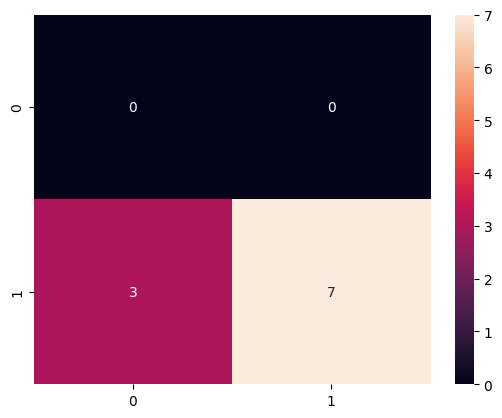

In [83]:
test_img,test_label=next(iter(test_data))
pred=model(test_img.to(device))
pred=pred.argmax(axis=1)
pred = pred.detach().cpu()
from sklearn.metrics import confusion_matrix
print( test_label)
cm=confusion_matrix(test_label,pred)
print(cm)
import seaborn as sns
sns.heatmap(cm,annot=True)

In [21]:
! wget -O dataset.zip https://www.dropbox.com/s/fdlnoh5stmumy0d/Kompiyuter.zip?dl=0

--2023-07-09 16:43:41--  https://www.dropbox.com/s/fdlnoh5stmumy0d/Kompiyuter.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6027:18::a27d:4812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fdlnoh5stmumy0d/Kompiyuter.zip [following]
--2023-07-09 16:43:42--  https://www.dropbox.com/s/raw/fdlnoh5stmumy0d/Kompiyuter.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4c1c0fc08c9686e5f9c083bbd9.dl.dropboxusercontent.com/cd/0/inline/B_hujwHuVCcvoAxhf8y6581MCvaCEIplYtkvSWp90_RAyzA1lZHJaPz-Z_ZyMZc9GTkcsKL7T96mFFtQgJiiTPL0odaPUxfXaGrnpzpxlnVUkMDMZZihM5FbL24WjTHeM0TKrsPBuya4GMaVe957_OdZ_RDHuhwgSAJqZdwiwjO1dA/file# [following]
--2023-07-09 16:43:42--  https://uc4c1c0fc08c9686e5f9c083bbd9.dl.dropboxusercontent.com/cd/0/inline/B_hujwHuVCcvoAxhf8y6581MCvaCEIplYtkvSWp90_RAyzA1lZHJaPz-Z_ZyMZc9GT

In [ ]:
!unzip dataset.zip

In [84]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [85]:
transform = T.Compose([
    T.Resize(size=(150,150)),
    T.ToTensor()
])

In [86]:
class KompyuterDataset(Dataset):

    def __init__(self, path, transform = None):
        # int for cross entryp loss
        self.path_list = list(path.glob('*/*.jpg'))
        self.transform = transform

    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]
        label = 0 if 'kompiyuter' in label else 1
        if transform != None:
            img = transform(img)

        return img, int(label)

    def __len__(self):
        return len(self.path_list)

In [87]:
train_path = pathlib.Path('/content/Kompiyuter/train')
test_path = pathlib.Path('/content/Kompiyuter/validation')

In [88]:
train_dataset = KompyuterDataset(train_path, transform)
test_dataset = KompyuterDataset(test_path, transform)

In [89]:
path_list = list(train_path.glob('*/*.jpg'))
path_test=list(test_path.glob('*/*.jpg'))

In [90]:
train_data = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=10, shuffle=True)

In [91]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (256,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)

        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)

        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)

        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)

        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)

        #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)

        output=self.fc(output)

        return output


In [92]:
model=ConvNet()

In [93]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [94]:
num_epochs = 5

In [95]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}

    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)

            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n

        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)

        return train_loss, train_accuracy

    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()

            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)

        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n

        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)

        return val_loss, val_accuracy

    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [96]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [99]:
trainer.train()

100%|██████████| 2/2 [00:00<00:00,  9.97it/s]



Epoch[1/5] 	 train_loss: 1.88420, train_acc: 0.94 	 val_loss: 12.72379 	 val_acc: 0.65


100%|██████████| 2/2 [00:00<00:00, 10.20it/s]



Epoch[2/5] 	 train_loss: 0.88480, train_acc: 0.97 	 val_loss: 7.60129 	 val_acc: 0.7


100%|██████████| 2/2 [00:00<00:00,  9.15it/s]



Epoch[3/5] 	 train_loss: 0.00009, train_acc: 1.00 	 val_loss: 11.77107 	 val_acc: 0.7


100%|██████████| 2/2 [00:00<00:00,  9.51it/s]



Epoch[4/5] 	 train_loss: 0.20016, train_acc: 0.99 	 val_loss: 7.92817 	 val_acc: 0.7


100%|██████████| 2/2 [00:00<00:00,  9.88it/s]


Epoch[5/5] 	 train_loss: 0.00000, train_acc: 1.00 	 val_loss: 6.04412 	 val_acc: 0.75


tensor([1, 0, 1, 1, 0, 0, 1, 0, 0, 0])
[[5 1]
 [1 3]]


<Axes: >

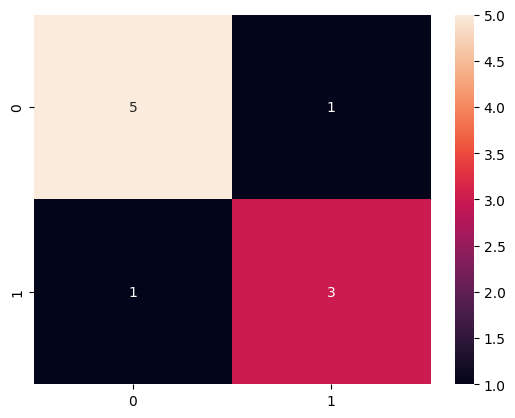

In [100]:
test_img,test_label=next(iter(test_data))
pred=model(test_img.to(device))
pred=pred.argmax(axis=1)
pred = pred.detach().cpu()
from sklearn.metrics import confusion_matrix
print( test_label)
cm=confusion_matrix(test_label,pred)
print(cm)
import seaborn as sns
sns.heatmap(cm,annot=True)